In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [2]:
# parameters
simulation_start_year = 2021
weeks_off_bt_crops = 2

In [3]:
df_G = pd.read_csv("grower_list.csv")

In [4]:
df_G.head()

,Site No.,Address,Med_Rec,Grower Class,Num Plants
0,1,"1680 B Marquette Avenue Bay City, MI",Medical,C,1500
1,2,"1204 West US Highway 2 Germfask, MI",Medical,C,1500
2,3,"1230 Mason Court Webberville, MI",Medical,C,1500
3,4,"34280 56th Street Bangor, MI",Medical,C,1500
4,5,"21055 E M48 Detour, MI",Medical,C,1500


In [5]:
df_A = pd.read_csv("assumptions.csv")

In [6]:
df_A

,#,Grow type,Weeks to harvest (low),Weeks to harvest (high),Begin week (low),Begin week (high),Ounces per plant (low),Ounces per plant (high)
0,1,Outdoor,24,32,13,24,10,17
1,2,Indoor - seed,12,16,1,27,5,15
2,3,Indoor - clone,9,16,1,24,5,15


In [7]:
np.random.seed(int(datetime.now().timestamp()))

In [8]:
random = np.random.randint(0, 3, size=len(df_G))  # 0 = Outdoor, 1 = Indoor-seed, 2 = Indoor-clone

In [9]:
def cycle_outin(crop_type):
    
    start_week = []; grow_duration = []; plant_size = [];
    
    for i in crop_type:
        start_week.append(np.random.randint(df_A['Begin week (low)'][i], df_A['Begin week (high)'][i])) 
        grow_duration.append(np.random.normal(np.mean([df_A['Weeks to harvest (low)'][i], df_A['Weeks to harvest (high)'][i]])))
        plant_size.append(np.random.normal(np.mean([df_A['Ounces per plant (low)'][i], df_A['Ounces per plant (high)'][i]])))
    
    harvest_time = [start_week[i] + grow_duration[i] for i in np.arange(len(crop_type))]
    harvest_week = [round(h) for h in harvest_time]
    return harvest_week, plant_size

In [10]:
def cycle_in(crop_type, start_date):
    
    grow_duration = []; plant_size = [];
    
    for i in crop_type:
        grow_duration.append(timedelta(weeks=(np.random.normal(np.mean([df_A['Weeks to harvest (low)'][i], df_A['Weeks to harvest (high)'][i]])))))
        plant_size.append(np.random.normal(np.mean([df_A['Ounces per plant (low)'][i], df_A['Ounces per plant (high)'][i]])))
            
    harvest_date = [start_date[i] + grow_duration[i] for i in np.arange(len(crop_type))]

    return harvest_date, plant_size

In [11]:
harvest_week, plant_size = cycle_outin(random)   # randomly select which growers are outdoor or indoor

In [12]:
from datetime import date
# convert week integers to dates
harvest_dates = []  
for w in harvest_week:
    y = simulation_start_year + int(w / 52)  # int truncates
    w = w % 52 + 1  # +1 for first week, because can't have week=0 in the iso func below
    harvest_dates.append(date.fromisocalendar(y, w, 1))  # (year, week, day of week)

In [13]:
df_G['Harvest Date'] = harvest_dates
df_G['Plant Oz'] = plant_size
df_G['Crop Type'] = random

In [14]:
df_G.sort_values(by=['Harvest Date']).head()

,Site No.,Address,Med_Rec,Grower Class,Num Plants,Harvest Date,Plant Oz,Crop Type
68,69,"16100 Washburne Road Grass Lake, MI",Medical,A,500,2021-03-29,10.394277,2
151,152,"23295 Blackstone Avenue Warren, MI",Medical,A,500,2021-03-29,8.342023,2
107,108,"3323 Associates Drive Burton, MI",Medical,C,1500,2021-04-05,11.112260,1
300,301,"523 West 9 Mile RD Hazel Park,MI 48030",Adult,C,1500,2021-04-05,10.831441,2
79,80,"2300 Spikes Lane Lansing, MI",Medical,B,1000,2021-04-05,8.925450,2


In [15]:
# new df of indoor growers
df_in = df_G[df_G['Crop Type'] > 0]
start_date = (df_in['Harvest Date'] + timedelta(weeks = weeks_off_bt_crops)).values.tolist()  # second round start dates 
df_in = df_in.drop(['Harvest Date', 'Plant Oz'], axis=1)  # drop these columns because going to simulate a second time

In [16]:
harvest_dates, plant_size = cycle_in(df_in['Crop Type'].values.tolist(), start_date)

In [17]:
df_in['Harvest Date'] = harvest_dates  # put new dates and plant sizes back in df
df_in['Plant Oz'] = plant_size

In [18]:
df_all = pd.concat([df_G, df_in], axis=0)

In [19]:
df_all['Harvest Amnt'] = df_all['Plant Oz'] * df_all['Num Plants']

In [20]:
df_all['Harvest Month'] = df_all['Harvest Date'].apply(lambda x: x.strftime('%Y-%m'))
df_plot = df_all.groupby(by=['Harvest Month'])['Harvest Amnt'].sum().reset_index()

In [21]:
df_all['Harvest Month'].max()

'2022-02'

Text(0, 0.5, 'Oz of Plant Harvested')

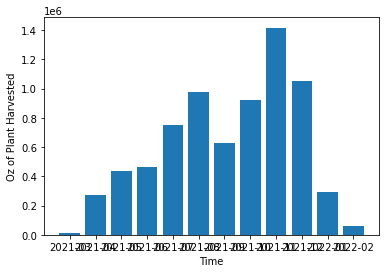

In [22]:
plt.bar(df_plot['Harvest Month'], df_plot['Harvest Amnt'])
plt.xlabel("Time")
plt.ylabel("Oz of Plant Harvested")

In [23]:
df_out_in_in = df_all[df_all['Crop Type'] == 1]

Text(0, 0.5, 'Ounces of Plant Harvested')

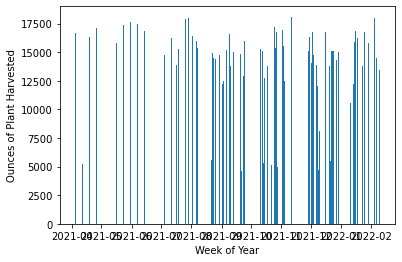

In [24]:
plt.bar(df_out_in_in['Harvest Date'], df_out_in_in['Harvest Amnt']); plt.xlabel("Week of Year"); plt.ylabel("Ounces of Plant Harvested")